## Mini-projet notebook template

- If you work on Google Colab, [![open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/jouvetg/glamod/blob/main/03_notebook/my_glacier.ipynb) and you will donwload the repo  below. Make sure to activate the GPU on Colab "Runtime" -> "Change Runtime Type" -> Slect GPU.

- If you work locally on your own PC, you can download the repo
```bash
git clone --depth 1 https://github.com/jouvetg/glamod.git
```
and then go the notebook folder, and work from there.

## Install IGM

Running IGM consists of running a python script `igm_run`, which is made of functions of the `igm` python package.  First of all, one needs to install igm as follows: (this may take a while, and it may crashes the first time, but should work the second time).

In [1]:
! pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple igm-model-testing-package==3.0.5
! pip install ml-dtypes==0.5.3

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.3
    Uninstalling ml_dtypes-0.5.3:
      Successfully uninstalled ml_dtypes-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.17.1 which is incompatible.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.17.1 which is incomp

## Download the data

Let's now download the repo with the data if you are using Colab

In [2]:
import sys, os

if "google.colab" in sys.modules:
    print("Running in Colab: cloning repo...")
    !git clone --depth 1 https://github.com/jouvetg/glamod.git
    !apt-get install tree -q
else:
    print("Running locally: using local files.")

Running in Colab: cloning repo...
Cloning into 'glamod'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 81 (delta 8), reused 61 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 14.05 MiB | 37.28 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (230 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tre

Let's now go the working folder

In [3]:
if "google.colab" in sys.modules:
    %cd /content/glamod/03_notebook

/content/glamod/03_notebook


# Modelling

Here, we model the Rhone Glacier (`RGI2000-v7.0-G-11-01706`) with IGM.

Wuse the module `oggm_shop` to download all necessary data. OGGM will download climate data (a time series), which will serve to generate a climate (temperature and precipitation in module `clim_oggm`) to compute a better Surface Mass Balance model. Note this parameter in the parameter file:

```yaml
  clim_oggm:
    clim_trend_array:
      - ["time", "delta_temp", "prec_scal"]
      - [ 1900,           0.0,         1.0]
      - [ 2020,           0.0,         1.0]
      - [ 2100,           4.0,         1.0]
```

Similar to the previous method, this array assigns weights to modify precipitation and temperature series based on a *neutral* climate period, typically defined as 1960-1990. By adjusting the temperature offset in the `delta_temp` column, for example, a value of -2.0 would create a climate scenario for the 1960-1990 period that is 2 degrees cooler. Likewise, by modifying the precipitation scaling in the `prec_scal` column, a value of 1.5 would result in a climate scenario that has 150% of the precipitation compared to the 1960-1990 average.

Finally, you can incorporate this parameter to provide global control for melt (note that the melt parameters in the PDD model are notoriously uncertain):

```yaml
   melt_enhancer: 0.7
```

Find more information about the generated climate [here](https://igm-model.org/latest/modules/processes/clim_oggm/).

Instead of using the Simple Surface Mass Balance `smb_simple`, and now that we have climate available, we will use the `smb_oggm` SMB, which is a monthly temperature index model as described [here](https://igm-model.org/latest/modules/processes/smb_oggm/).

Let's run IGM

In [4]:
! igm_run +experiment=params

2025-11-26 08:15:18.849917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-26 08:15:18.881746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-26 08:15:18.891385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-26 08:15:18.924696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 08:15:22.892024: W tensorflow/compiler/tf2

## Visualizing Climate Data

Let's explore the historical climate data that was used for the glacier simulation. We will open the `climate_historical.nc` file and plot the smoothed precipitation and temperature time series on the same graph.

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Open the climate data
climate_data = xr.open_dataset('data/RGI2000-v7.0-G-11-01706/climate_historical.nc')

# Extract temperature and precipitation
temp = climate_data['temp'].values
prcp = climate_data['prcp'].values
time = climate_data['time'].values

# Apply smoothing (moving average with window size of 12 months for annual smoothing)
window_size = 12
temp_smoothed = uniform_filter1d(temp, size=window_size, mode='nearest')
prcp_smoothed = uniform_filter1d(prcp, size=window_size, mode='nearest')

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color=color, fontsize=12)
ax1.plot(time, temp_smoothed, color=color, linewidth=2, label='Temperature (smoothed)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create second y-axis for precipitation
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precipitation (mm)', color=color, fontsize=12)
ax2.plot(time, prcp_smoothed, color=color, linewidth=2, label='Precipitation (smoothed)')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and layout
plt.title('Historical Climate Data (Smoothed)', fontsize=14, fontweight='bold')
fig.tight_layout()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Display some basic statistics
print(f"\nClimate Data Summary:")
print(f"Time period: {time[0]} to {time[-1]}")
print(f"Temperature range: {temp.min():.2f}°C to {temp.max():.2f}°C")
print(f"Mean temperature: {temp.mean():.2f}°C")
print(f"Precipitation range: {prcp.min():.2f} to {prcp.max():.2f} mm")
print(f"Mean precipitation: {prcp.mean():.2f} mm")

FileNotFoundError: [Errno 2] No such file or directory: b'/content/glamod/03_notebook/data/RGI2000-v7.0-G-11-01706/climate_historical.nc'

### Analyzing the time series results

Let's examine how the glacier evolved under the climate scenario:

Found 1 time series file(s). Using: outputs/2025-11-26/08-15-32/output_ts.nc

Reading time series data from: /content/glamod/03_notebook/outputs/2025-11-26/08-15-32/output_ts.nc



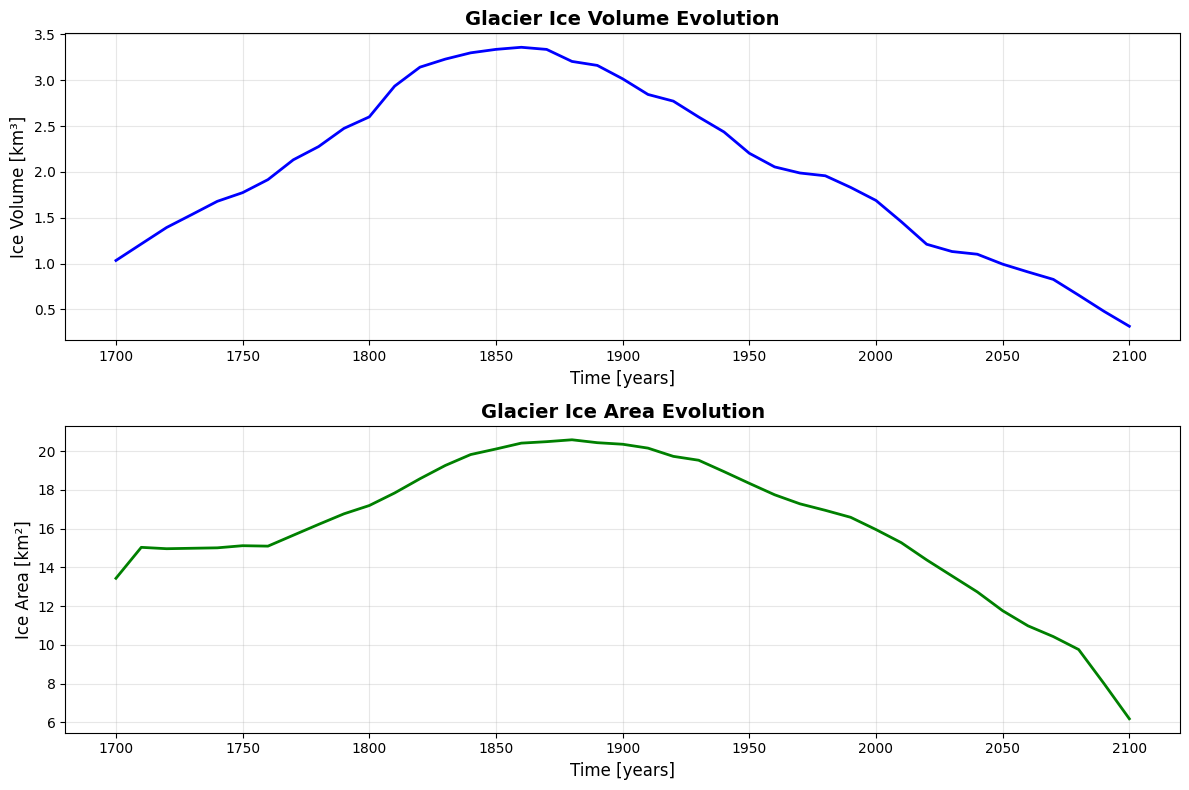


SUMMARY STATISTICS

Ice Volume:
  Initial: 1.03 km³
  Final:   0.32 km³
  Change:  -0.72 km³

Ice Area:
  Initial: 13.43 km²
  Final:   6.18 km²
  Change:  -7.25 km²


In [7]:
from helper import *
import glob
import os

# Find all time series files and select the most recent one
ts_files = sorted(glob.glob('outputs/*/*/output_ts.nc'))

if ts_files:
    # Get the absolute path to ensure it works from any directory
    ts_file = os.path.abspath(ts_files[-1])
    print(f"Found {len(ts_files)} time series file(s). Using: {ts_files[-1]}\n")
    # Analyze the time series from the most recent run
    analyze_time_series(ts_file)
else:
    print("No output_ts.nc file found. Please run the model first.")

## Glacier Ice Thickness Evolution

Let's visualize how the ice thickness evolved over time in a 4x4 grid showing 16 time steps.

Found 1 output file(s)



/content/glamod/03_notebook/helper.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


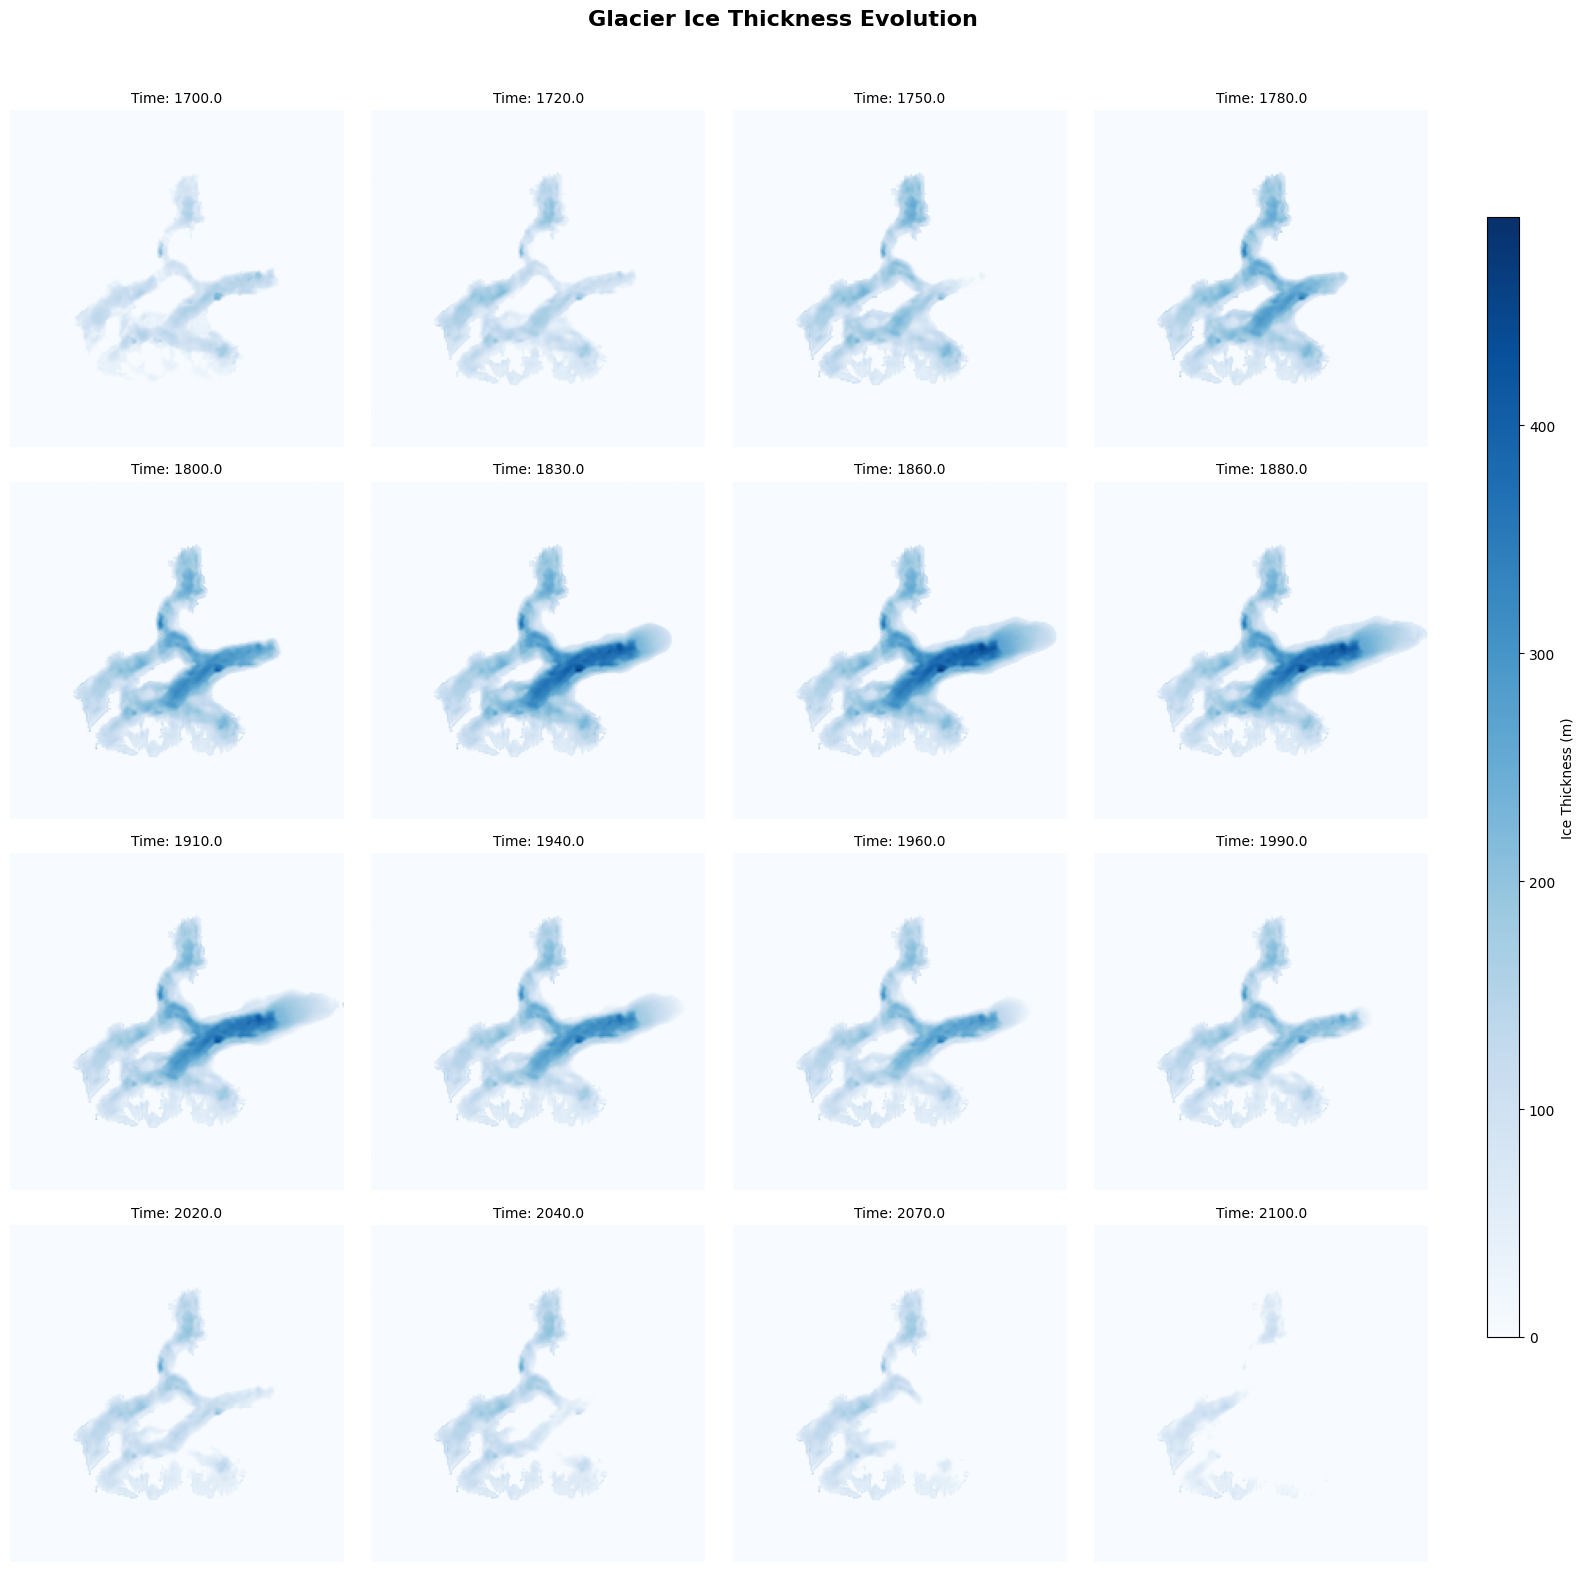

In [8]:
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')

if A:
    print(f"Found {len(A)} output file(s)\n")
    # Animate ice thickness evolution
    animate_glacier_evolution(
        nc_file=A[-1],
        variable='thk',
        log_scale=False
    )
else:
    print("No output.nc files found. Please run the model first.")

## Glacier Velocity Evolution

Now let's visualize the ice velocity magnitude evolution in log scale. This shows the flow dynamics and where the glacier is moving fastest.

Found 1 output file(s)



/content/glamod/03_notebook/helper.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


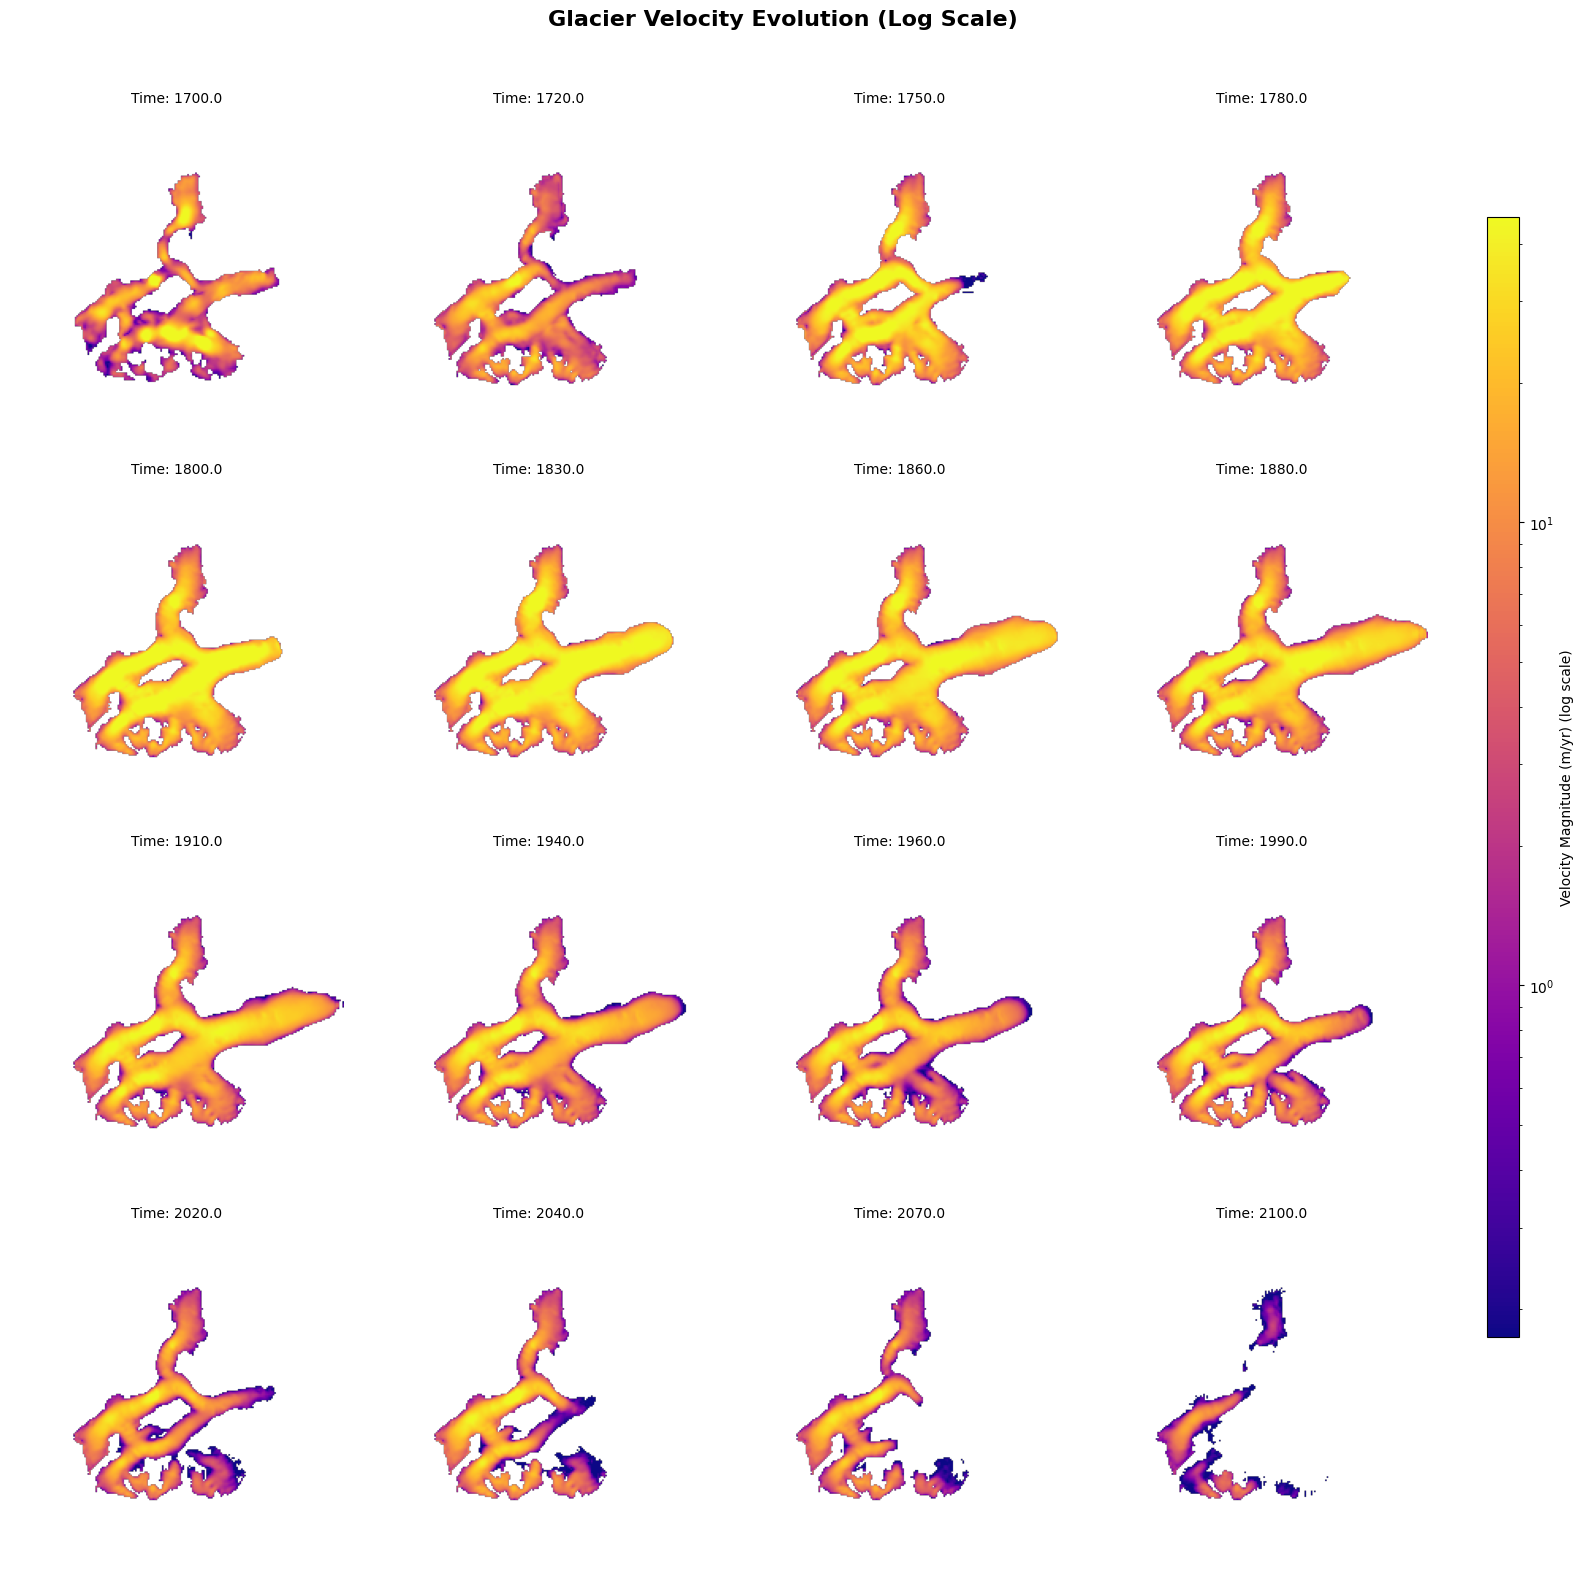

In [9]:
import importlib
import helper
importlib.reload(helper)
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')

if A:
    print(f"Found {len(A)} output file(s)\n")
    # Plot velocity evolution (log scale)
    animate_glacier_evolution(
        nc_file=A[-1],
        variable='velbar_mag',
        log_scale=True
    )
else:
    print("No output.nc files found. Please run the model first.")

## Glacier Cross-Section Along Flowline

Now let's visualize how the glacier thickness evolved along the flowline over time. This will show the bedrock elevation, ice thickness, and surface elevation at 16 different time steps in a 4x4 grid.

Each subplot includes:
- **Left y-axis (blue)**: Elevation in meters - showing bedrock (black line), ice (blue fill), and surface (blue line)
- **Right y-axis (red)**: Ice velocity magnitude in m/yr (red line)

**Note:** The flowline automatically extends upward from the OGGM downstream line to capture the upper part of the glacier where ice is present.

In [ ]:
import importlib
import helper
importlib.reload(helper)
from helper import *
import glob

# Find all output files
A = glob.glob('outputs/*/*/output.nc')

if A:
    print(f"Found {len(A)} output file(s)\n")
    # Plot flowline evolution for the last run
    plot_flowline_evolution(
        nc_file=A[-1],
        flowline_file='data/RGI2000-v7.0-G-11-01706/downstream_line.pkl',
        glacier_grid_file='data/RGI2000-v7.0-G-11-01706/glacier_grid.json'
    )
else:
    print("No output.nc files found. Please run the model first.")

## Compare Modeled vs Observed Velocity

Compare the modeled surface velocity with observations from the input data.

Found 1 output file(s). Using: outputs/2025-11-26/08-15-32/output.nc

Comparing modeled (year 2020) vs observed velocity

Using modeled data from year: 2020.0


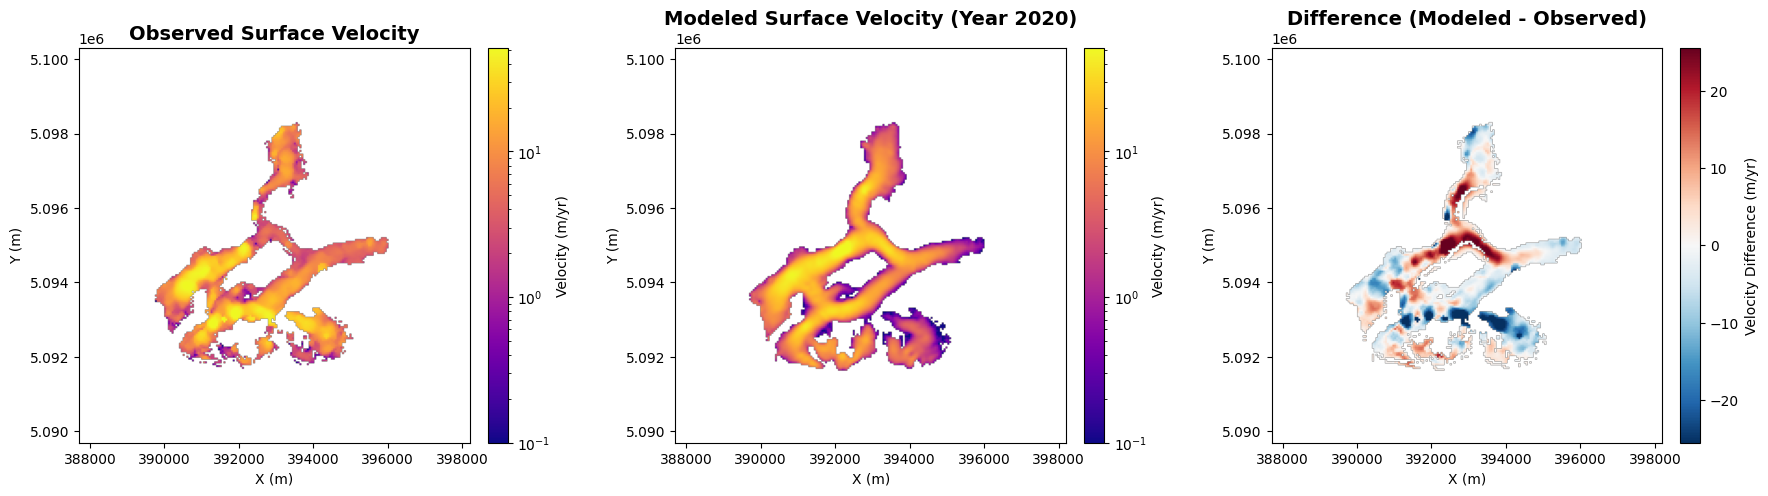


VELOCITY COMPARISON STATISTICS
Correlation coefficient (R): 0.518
RMSE: 11.41 m/yr
Bias (modeled - observed): -0.30 m/yr
Number of points: 5053

Observed velocity range: 0.00 - 66.09 m/yr
Modeled velocity range: 0.02 - 65.00 m/yr


In [12]:
import importlib
import helper
importlib.reload(helper)
from helper import compare_modeled_observed_velocity
import glob

# Find all output files and use the latest one
output_files = sorted(glob.glob('outputs/*/*/output.nc'))

if output_files:
    print(f"Found {len(output_files)} output file(s). Using: {output_files[-1]}\n")
    # Compare modeled velocity (year 2020) with observed velocity
    compare_modeled_observed_velocity(
        input_file='data/input.nc',
        output_file=output_files[-1],
        year=2020
    )
else:
    print("No output.nc files found. Please run the model first.")

    plt.savefig("velocity_comparison_2020.png", format="png", dpi=600, bbox_inches="tight")
plt.close()

